### 1/ Brief description of the problem and data

Given a collection of tweets labeled in relation to disasters, the present notebook will attempt to create a machine learning model able to learn and guess correctly the relation between the tweets content and the results. Given the tweets are texts, an LSTM seems to be a natural fit to this problem.

The dataset provided on Kaggle (url: https://www.kaggle.com/competitions/nlp-getting-started/overview) contains more than 7000 tweets.

### 2/ Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

Let's start with the usual imports.

In [1]:
# usual import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Then, let's retrieve the train and test sets.

In [2]:
# retrieve train and test set
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Let's look at the top of the train set.

In [3]:
# first look at train set
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


We can see a lot of *NaN* in the **keyword** and **location** columns. We will have to clean them. Let's try to get a sense of the **id** and **target** columns.

In [4]:
# trying to get a sense of the data
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


These columns seems numerical, so let's check for *Null* and *NaN* in the dataset.

In [5]:
# checking for null/na
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


We can see we need to clean the **keyword** and **location** column. We will replace *NaN* with a blank string.

In [6]:
# replace NA with a blank
train['keyword'] = train['keyword'].fillna("")
train['location'] = train['location'].fillna("")

# confirm update
train.head()

,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this #earthquake M...,1
1,4,,,Forest fire near La Ronge Sask. Canada,1
2,5,,,All residents asked to 'shelter in place' are ...,1
3,6,,,"13,000 people receive #wildfires evacuation or...",1
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1


Let's validate our cleaning is successful.

In [7]:
# confirm update
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7613 non-null   object
 2   location  7613 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Ok, let's have a deeper look at the **keyword** column.

In [8]:
# check list of unique keyword
print(len(train['keyword'].unique()))
print(train['keyword'].unique()[0:10])

222
['' 'ablaze' 'accident' 'aftershock' 'airplane%20accident' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon']


Nothing of note, let's check the distribution per keyword.

<Axes: >

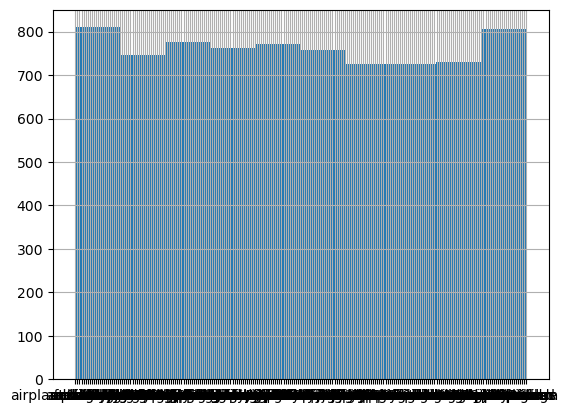

In [9]:
# histogram of keyword
train['keyword'].hist()

We can see the data seems more or less evenly distributed.

Let's do the same checks for the **location** column.

In [10]:
# check list of unique location
print(len(train['location'].unique()))
print(train["location"].unique()[0:10])

3342
['' 'Birmingham' 'Est. September 2012 - Bristol' 'AFRICA'
 'Philadelphia, PA' 'London, UK' 'Pretoria' 'World Wide!!'
 'Paranaque City' 'Live On Webcam']


We can see some special character, which are probably not usefull for our analysis. Let's remove them.

In [11]:
# cleaning of location names
train['location'] = train['location'].apply(lambda x : x.strip().capitalize()).str.replace('\W', '', regex=True)

Now let's check the distribution.

<Axes: >

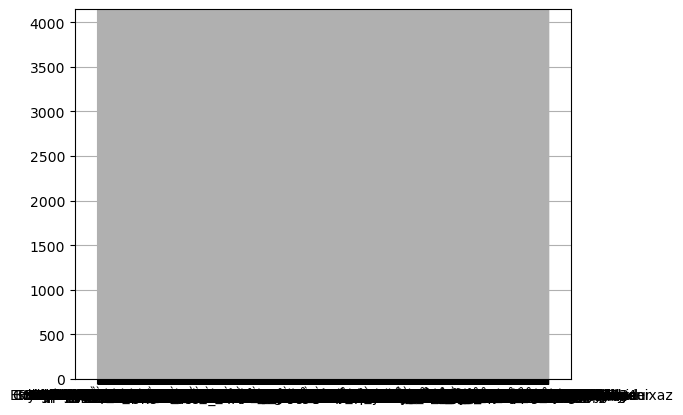

In [12]:
# histogram of location
train['location'].hist()

This graph is not providing any information usefull information.

Let's check the distribution of the **label** column.

In [13]:
# look at distribution of results
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

There are more tweets not linked to disasters than tweets that are, but the margin is not significant.

Finally, let's clean the text of the tweets themselves to remove special characters.

In [14]:
# clean text from special character
train['text'] = train['text'].apply(lambda x : x.strip().capitalize()).str.replace('\W', '', regex=True)

Our data is now ready.

### 3/ Model Architecture

Since we are handling text, we need to tokenize the words to feed the LSTM model later.

In [15]:
# instance tokenizer with 4000 words max
tokenizer_ = Tokenizer(num_words = 4000, split = ' ')

# fit on train text
tokenizer_.fit_on_texts(train['text'].values)

# retrieve sequences
train_token = tokenizer_.texts_to_sequences(train['text'].values)
train_token = pad_sequences(train_token)

Now let's do a classic 80%/20% train/val split.

In [16]:
# standard train/test split
x_train, x_val, y_train, y_val = train_test_split(train_token, train['target'], test_size = 0.2)

We are now ready to create our model. We will keep it simple and use:
* one _embedding_ layer to feed the data
* one _dropout_ layer to prevent overfitting
* one _LSTM_ layer
* one _dense_ layer with _sigmoid_ for binary classification of the results

In [17]:
# instance model
model = Sequential()
# add input
model.add(Embedding(4000, 64, input_length = train_token.shape[1]))
# add dropout to prevent overfitting
model.add(Dropout(0.2))
# add LSTM layer
model.add(LSTM(64,dropout=0.25, recurrent_dropout=0.25))
# add acitvation layer
model.add(Dense(1, activation='sigmoid'))

# choose optimizer (here RMSprop)
opt = optimizers.RMSprop(learning_rate=0.001)

We can now compile our model.

In [18]:
# compile model
model.compile(loss = 'binary_crossentropy', optimizer=opt, metrics = ['accuracy'])

# check model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 64)             256000    
                                                                 
 dropout (Dropout)           (None, 4, 64)             0         
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 289,089
Trainable params: 289,089
Non-trainable params: 0
_________________________________________________________________


The model is ready, so let's train it.

In [19]:
# train the model
history = model.fit(x_train, y_train, epochs = 20, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/20
96/96 [==============================] - 2s 8ms/step - loss: 0.6837 - accuracy: 0.5742 - val_loss: 0.6882 - val_accuracy: 0.5509
Epoch 2/20
96/96 [==============================] - 0s 4ms/step - loss: 0.6824 - accuracy: 0.5752 - val_loss: 0.6904 - val_accuracy: 0.5509
Epoch 3/20
96/96 [==============================] - 0s 5ms/step - loss: 0.6813 - accuracy: 0.5752 - val_loss: 0.6898 - val_accuracy: 0.5509
Epoch 4/20
96/96 [==============================] - 0s 5ms/step - loss: 0.6802 - accuracy: 0.5752 - val_loss: 0.6880 - val_accuracy: 0.5509
Epoch 5/20
96/96 [==============================] - 0s 4ms/step - loss: 0.6761 - accuracy: 0.5759 - val_loss: 0.6903 - val_accuracy: 0.5509
Epoch 6/20
96/96 [==============================] - 0s 4ms/step - loss: 0.6682 - accuracy: 0.5768 - val_loss: 0.6886 - val_accuracy: 0.5522
Epoch 7/20
96/96 [==============================] - 0s 4ms/step - loss: 0.6510 - accuracy: 0.5890 - val_loss: 0.6878 - val_accuracy: 0.5522
Epoch 8/20
96/96 [==

We can now move onto analyzing our model performance.

### 4/ Results and Analysis

We can see that the model does not perform well:
* while the accuracy of the train set increases, the validate set accuracy doesn't
* the accuracy of the train set plateaus, and an _early stopping_ could be used
* the overall accuracy of the train set doesn't reach 80%
* the accuracy of the validate set is around 0.5, which is to say as good as random

Let's check the final prediction accuracy.

In [20]:
# predictions for validate set
y_pred = model.predict(x_val).round()
metrics.accuracy_score(y_val, y_pred)

48/48 [==============================] - 0s 1ms/step


0.5364412344057781

The accuracy is indeed around 0.5.

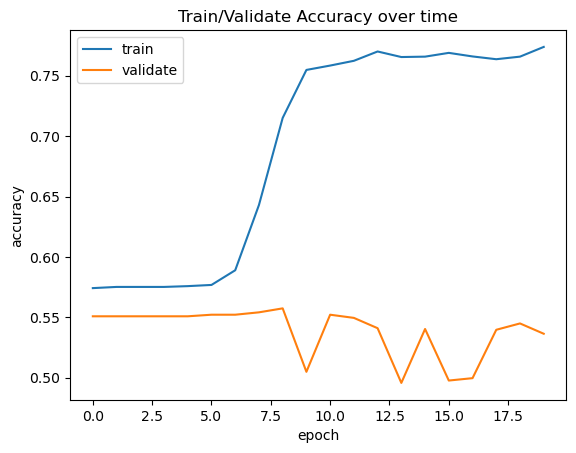

In [21]:
# plot accuracy (train/val) history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Train/Validate Accuracy over time')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

We can clearly see that the accuracy of the train set increases quickly to stabilise at around 77%.

However the accuracy of the validate set seems to fluctuate around the 50% mark, that is to say random.

This last part is extremely puzzling, the model tells us it can effectively learn, but the learning is useless to the validate set.

#### 4.5/ Submission

In order to prepare the submission, we need to clean the test set in a manner similar to the train set.

In [22]:
# clean test set
test['keyword'] = test['keyword'].fillna("")
test['location'] = test['location'].fillna("")
test['text'] = test['text'].apply(lambda x : x.strip().capitalize()).str.replace('\W', '', regex=True)
test['location'] = test['location'].apply(lambda x : x.strip().capitalize()).str.replace('\W', '', regex=True)

Next, we need to tokenize the words of the test set.

In [23]:
# retieve sequences for test
test_token = tokenizer_.texts_to_sequences(test['text'].values)
test_token = pad_sequences(test_token, maxlen = 4)

We are now ready to predict the output of the test set.

In [24]:
# generate prediction using our model
y_hat = model.predict(test_token).round().astype('int')

102/102 [==============================] - 0s 909us/step


Let's write the ouput into a csv file.

In [25]:
# write prediction to file for submission
predictions = np.transpose(y_hat)[0]
submission = pd.read_csv("sample_submission.csv")
submission['id'] = test['id']
submission['target'] = predictions
submission.to_csv('submission.csv', index=False)

### 5/ Conclusion

While this project is a failure, as the model fails to predict barely better than average, it was very interesting overall.

In order to increase the accuracy of the validate set, I tried the following, without success:
* concatenate the **keyword** and **location** to the **text** column
* change the _dropout rate_
* change the _number of words_
* change the _optimizer_
* change the optimizer _learning rate_

At best, the accuracy of the train set further increased to 80%, but the accuracy of the validate set never overcome 60%. Some of the noted effects were a stabilization of the accuracy curve over time, but the end results were disappointing regardless.

If I were to work on this dataset again, here are some ideas to obtain a better score:
* provide more in-depth data cleaning of the tweets texts
* use a completely different model than LSTM
* use LSTM but make it much deeper